In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
df = pd.read_csv('./data/ytcb.csv')
df

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...
...,...,...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",/watch?v=mJBOQr_-8_Y,Art&Music,Step by step video on creating an art journal ...
11207,Ar-Tea Collage * Mixed Media Art,/watch?v=GOihUhnZxtw,Art&Music,"By: Ilene McInnes,\nMixed media Art and inspir..."
11208,DIY Mixed Media Art Collage Greeting Cards / M...,/watch?v=BchUtLfjews,Art&Music,Make your own Mixed Media Greeting Cards\n\nHe...
11209,Art Collage Process DecoJournal using Rice Pap...,/watch?v=FlQ_j-cflQc,Art&Music,Art Collage Process DecoJournal using Rice Pap...


In [3]:
def label_clickbait(title):
    clickbait_keywords = ["shocking", "you won't believe", "amazing", "powerful", "unbelievable", "exclusive",'top','the best','rare', 'best', 'insane', 'crazy', 'challenge']
    forbidden_patterns = [
        r'\d+\s+foods\s+you\s+need\s+to\s+eat\s+before\s+you\s+die',
        r'\d+\s+food\s+you\s+need\s+to\s+eat\s+in\s+your\s+lifetime',
    ]
    
    for keyword in clickbait_keywords:
        if keyword in title.lower():
            return 1

    for pattern in forbidden_patterns:
        if re.search(pattern, title, re.IGNORECASE):
            return 1
            
    if title.isupper():
        return 1
        
    return 0

In [4]:
df['Clickbait'] = df['Title'].apply(label_clickbait)

In [5]:
df

,Title,Videourl,Category,Description,Clickbait
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...,1
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...,1
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...,1
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...,0
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...,0
...,...,...,...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",/watch?v=mJBOQr_-8_Y,Art&Music,Step by step video on creating an art journal ...,0
11207,Ar-Tea Collage * Mixed Media Art,/watch?v=GOihUhnZxtw,Art&Music,"By: Ilene McInnes,\nMixed media Art and inspir...",0
11208,DIY Mixed Media Art Collage Greeting Cards / M...,/watch?v=BchUtLfjews,Art&Music,Make your own Mixed Media Greeting Cards\n\nHe...,0
11209,Art Collage Process DecoJournal using Rice Pap...,/watch?v=FlQ_j-cflQc,Art&Music,Art Collage Process DecoJournal using Rice Pap...,0


In [6]:
df['Clickbait'].sum()

1487

In [7]:
smote = SMOTE(sampling_strategy='auto')

In [8]:
title = df['Title'].values
labels = df['Clickbait'].values

In [9]:
title_train, title_test, y_train, y_test = train_test_split(title, labels)
print(title_train.shape, title_test.shape, y_train.shape, y_test.shape)

(8408,) (2803,) (8408,) (2803,)


In [10]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(title)

X_train = tokenizer.texts_to_sequences(title_train)
x_test = tokenizer.texts_to_sequences(title_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [11]:
X_train_smote = X_train.reshape(X_train.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_train_smote, y_train)
X_resampled = X_resampled.reshape(X_resampled.shape[0], maxlen, -1)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
__________________________________________________

In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_resampled, y_resampled, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5838
Epoch 1: val_accuracy improved from -inf to 0.57438, saving model to weights.h5
29/29 [==============================] - 31s 1s/step - loss: 0.6908 - accuracy: 0.5838 - val_loss: 0.6909 - val_accuracy: 0.5744
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.6739
Epoch 2: val_accuracy improved from 0.57438 to 0.75883, saving model to weights.h5
29/29 [==============================] - 31s 1s/step - loss: 0.6729 - accuracy: 0.6739 - val_loss: 0.6526 - val_accuracy: 0.7588
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.6133 - accuracy: 0.7061
Epoch 3: val_accuracy did not improve from 0.75883
29/29 [==============================] - 31s 1s/step - loss: 0.6133 - accuracy: 0.7061 - val_loss: 0.6346 - val_accuracy: 0.7331
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.7401
Epoch 4: val_accuracy i

In [26]:
oversampler = RandomOverSampler(sampling_strategy='auto')

In [27]:
X_train_oversampled = X_train.reshape(X_train.shape[0], -1)

X_oversampled, y_oversampled = oversampler.fit_resample(X_train_oversampled, y_train)

X_oversampled = X_oversampled.reshape(X_oversampled.shape[0], maxlen, -1)

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
________________________________________________

In [30]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='balancing.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_oversampled, y_oversampled, batch_size=512, validation_data=(x_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5958
Epoch 1: val_accuracy improved from -inf to 0.83090, saving model to balancing.h5
29/29 [==============================] - 31s 1s/step - loss: 0.6878 - accuracy: 0.5958 - val_loss: 0.6724 - val_accuracy: 0.8309
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7887
Epoch 2: val_accuracy did not improve from 0.83090
29/29 [==============================] - 30s 1s/step - loss: 0.6360 - accuracy: 0.7887 - val_loss: 0.6266 - val_accuracy: 0.7292
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.8189
Epoch 3: val_accuracy improved from 0.83090 to 0.84196, saving model to balancing.h5
29/29 [==============================] - 31s 1s/step - loss: 0.5055 - accuracy: 0.8189 - val_loss: 0.4221 - val_accuracy: 0.8420
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8992
Epoch 4: val_accura

In [52]:
model.load_weights('balancing.h5')
model.save('model.keras')

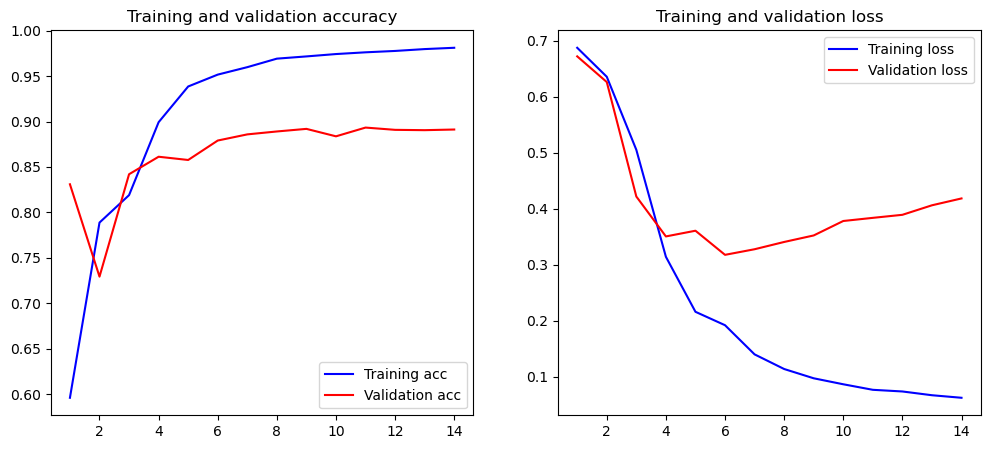

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

88/88 [==============================] - 3s 33ms/step


<Figure size 640x480 with 0 Axes>

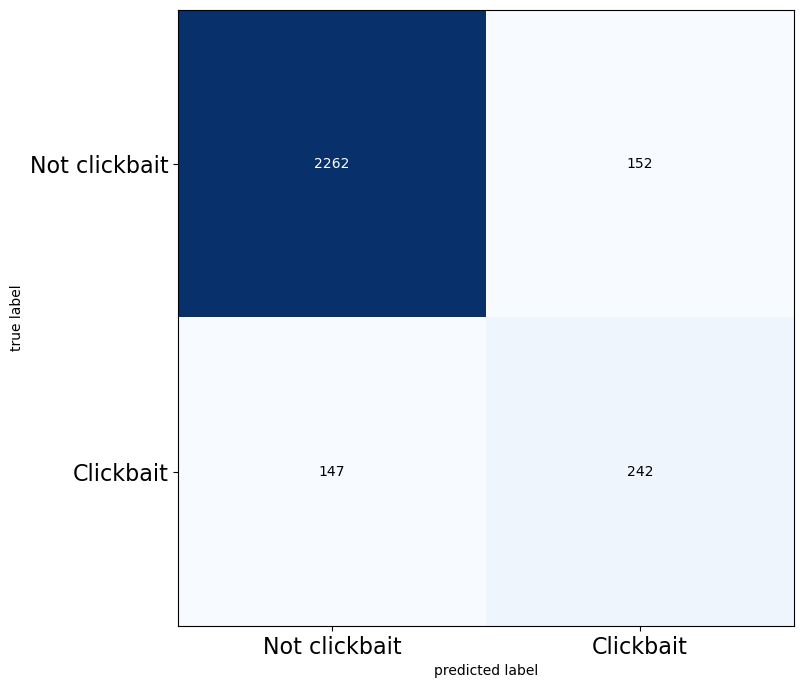

In [54]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [55]:
test = ['silencers in video games', 'a night to remember', 'going INSANE with the spas-12 | Rainbow Six: Siege', 'Top 12 best food to try in Northern India', 'I am financially ruined at 5 years old', 'Metacritic AWFUL Top 100 Racing Games Ranking', 'cum.com BEST CUMMING TECHNIQUES', 'TOP 52 AMAZING FORTNITE BATTLEPASSES']
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=maxlen)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 0s 38ms/step
silencers in video games - Not Clickbait
a night to remember - Not Clickbait
going INSANE with the spas-12 | Rainbow Six: Siege - Clickbait
Top 12 best food to try in Northern India - Clickbait
I am financially ruined at 5 years old - Not Clickbait
Metacritic AWFUL Top 100 Racing Games Ranking - Clickbait
cum.com BEST CUMMING TECHNIQUES - Clickbait
TOP 52 AMAZING FORTNITE BATTLEPASSES - Clickbait


In [56]:
model = tf.keras.models.load_model('./model.keras')

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 500, 32)           8320      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 168,353
Trainable params: 168,353
Non-trainable params: 0
________________________________________________

In [58]:
loss, acc = model.evaluate(x_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

88/88 [==============================] - 3s 32ms/step - loss: 0.3840 - accuracy: 0.8933
Restored model, accuracy: 89.33%
